# Buy when Yields are Low

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

import utils as self_utils
from quantified_strategies import strategy_utils

## Rules

- Buy S&P 500 at the close when the 10 year yield drops below its 15-day exponential moving average; and
- Exit at the close when the yield crosses above its 15-day exponential moving average.

In [2]:
results = self_utils.run(ticker="VUSA.LSE", start=dt.date(2020, 1, 1), end=dt.date.today(), full=True, asset_day_after=True)
results

{}
remove api from here


,asset,active,ret,ret_shifted,strat_ret,cum_strat_ret,cum_hodl_ret,enter_flag,trade_number
Date,,,,,,,,,
2020-01-02,46.7625,False,NaN,-0.005970,-0.0,0.000000,-0.005970,False,0
2020-01-03,46.9050,False,0.003047,0.006113,0.0,0.000000,0.000107,False,0
2020-01-06,46.6250,False,-0.005970,0.004050,0.0,0.000000,0.004157,False,0
2020-01-07,46.9100,False,0.006113,0.009873,0.0,0.000000,0.014071,False,0
2020-01-08,47.1000,False,0.004050,0.002077,0.0,0.000000,0.016177,False,0
...,...,...,...,...,...,...,...,...,...
2024-02-27,75.8100,False,-0.004171,0.001741,0.0,0.603504,0.625733,False,23
2024-02-28,76.1225,False,0.004122,0.007540,0.0,0.603504,0.637992,False,23
2024-02-29,76.2550,False,0.001741,-0.001009,-0.0,0.603504,0.636339,False,23


In [3]:
START = dt.date(2020, 1, 1)
ASSET_DAY_AFTER = True


In [4]:
TICKER = "SPY5.L" #5.DE"
# TICKER = "NQSE.DE"
# TICKER = "QQQ3.MI"
TICKER = "SPY"
TICKER = "VUSA.LSE"

In [23]:
ty10 = yf.download("^TNX", progress=False)["Close"]
px = strategy_utils.get_data(ticker=TICKER, columns="Close", flt=False)

px = px.reindex(index=px.index.union(ty10.index), method="ffill")
ty10 = ty10.reindex(index=px.index.union(ty10.index), method="ffill")

ty10 = ty10[ty10.index.date >= START]
px = px[px.index.date >= START]
px

{}
remove api from here


Date
2020-01-02    46.7625
2020-01-03    46.9050
2020-01-06    46.6250
2020-01-07    46.9100
2020-01-08    47.1000
               ...   
2024-02-27    75.8100
2024-02-28    76.1225
2024-02-29    76.2550
2024-03-01    76.8300
2024-03-04    76.7525
Name: Close, Length: 1075, dtype: float64

In [24]:
ty10_15_day_ma = self_utils.calculate_ema(data=ty10, window=15)
ty10_15_day_ma

Date
2020-01-02    1.882000
2020-01-03    1.870250
2020-01-06    1.862844
2020-01-07    1.858363
2020-01-08    1.860318
                ...   
2024-02-27    4.251462
2024-02-28    4.254279
2024-02-29    4.253994
2024-03-01    4.244745
2024-03-04    4.241527
Name: Close, Length: 1075, dtype: float64

In [25]:
signal1 = self_utils.get_position(treasury=ty10, window=15)
signal1.head(5)

Date
2020-01-02    False
2020-01-03    False
2020-01-06    False
2020-01-07    False
2020-01-08    False
Name: Close, dtype: bool

In [26]:
signal2 = self_utils.get_position(treasury=ty10, window=15, reverse=True)
signal2.head(5)

Date
2020-01-02    False
2020-01-03    False
2020-01-06    False
2020-01-07    False
2020-01-08    False
Name: Close, dtype: bool

In [27]:
hodl_signal = pd.Series(1, index=signal1.index)

In [28]:
rets = px.pct_change().shift(-1-ASSET_DAY_AFTER)
rets = rets.reindex(signal1.index, fill_value=False)
rets

Date
2020-01-02   -0.005970
2020-01-03    0.006113
2020-01-06    0.004050
2020-01-07    0.009873
2020-01-08    0.002077
                ...   
2024-02-27    0.001741
2024-02-28    0.007540
2024-02-29   -0.001009
2024-03-01         NaN
2024-03-04         NaN
Name: Close, Length: 1075, dtype: float64

In [29]:
portfolio1_returns = (rets * signal1).dropna()
portfolio1_value = (portfolio1_returns + 1).cumprod()
portfolio1_value.head(5)

Date
2020-01-02    1.0
2020-01-03    1.0
2020-01-06    1.0
2020-01-07    1.0
2020-01-08    1.0
Name: Close, dtype: float64

In [30]:
portfolio2_returns = (rets * signal2).dropna()
portfolio2_value = (portfolio2_returns + 1).cumprod()
portfolio2_value.head(5)

Date
2020-01-02    1.0
2020-01-03    1.0
2020-01-06    1.0
2020-01-07    1.0
2020-01-08    1.0
Name: Close, dtype: float64

In [31]:
hodl_value = ((rets * hodl_signal).dropna() + 1).cumprod()
hodl_ret = (rets * hodl_signal).dropna().cumsum()
hodl_value.head(5)

Date
2020-01-02    0.994030
2020-01-03    1.000107
2020-01-06    1.004157
2020-01-07    1.014071
2020-01-08    1.016177
dtype: float64

## Plot Strategy Results

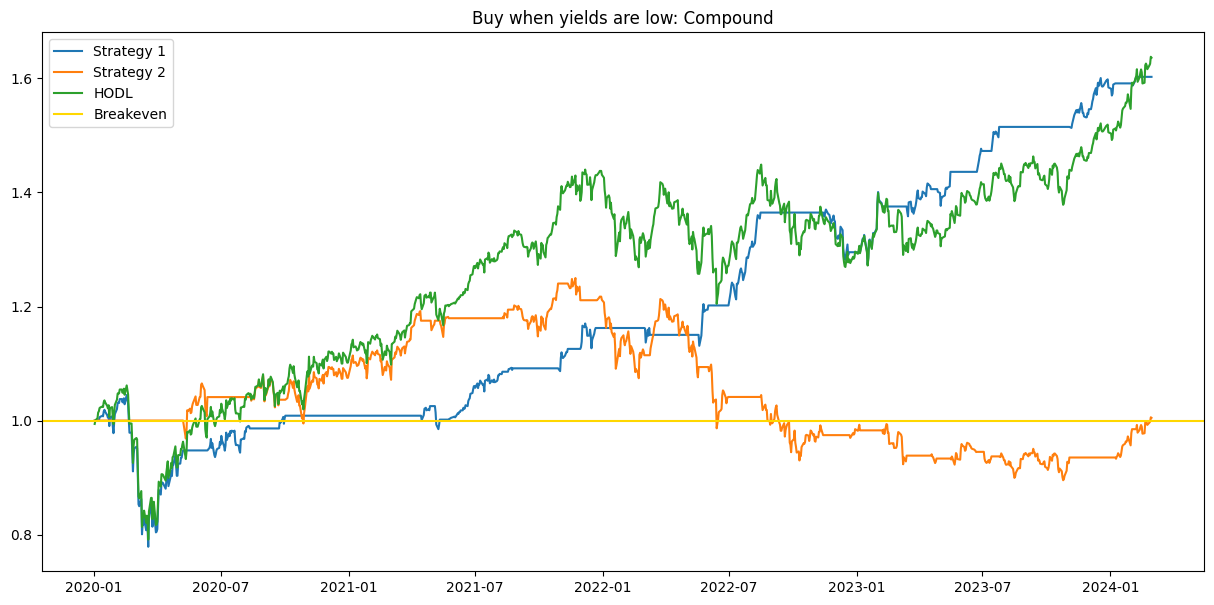

In [32]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(portfolio1_value, label="Strategy 1")
ax.plot(portfolio2_value, label="Strategy 2")
ax.plot(hodl_value, label="HODL")
ax.axhline(y=1, label="Breakeven", color="gold")

ax.legend(loc="upper left")
plt.title("Buy when yields are low: Compound")
plt.show()

In [33]:
ty10.loc[:dt.date(2020, 3, 10)]

Date
2020-01-02    1.882
2020-01-03    1.788
2020-01-06    1.811
2020-01-07    1.827
2020-01-08    1.874
2020-01-09    1.858
2020-01-10    1.825
2020-01-13    1.848
2020-01-14    1.818
2020-01-15    1.788
2020-01-16    1.809
2020-01-17    1.836
2020-01-20    1.836
2020-01-21    1.769
2020-01-22    1.769
2020-01-23    1.740
2020-01-24    1.681
2020-01-27    1.605
2020-01-28    1.641
2020-01-29    1.594
2020-01-30    1.558
2020-01-31    1.520
2020-02-03    1.520
2020-02-04    1.603
2020-02-05    1.649
2020-02-06    1.644
2020-02-07    1.578
2020-02-10    1.547
2020-02-11    1.590
2020-02-12    1.630
2020-02-13    1.617
2020-02-14    1.588
2020-02-17    1.588
2020-02-18    1.556
2020-02-19    1.570
2020-02-20    1.525
2020-02-21    1.471
2020-02-24    1.377
2020-02-25    1.330
2020-02-26    1.310
2020-02-27    1.299
2020-02-28    1.127
2020-03-02    1.088
2020-03-03    1.010
2020-03-04    0.992
2020-03-05    0.926
2020-03-06    0.706
2020-03-09    0.499
2020-03-10    0.748
Name: Close, dt

In [34]:
results.loc[:dt.date(2020, 3, 10)]

,asset,active,ret,ret_shifted,strat_ret,cum_strat_ret,cum_hodl_ret,enter_flag,trade_number
Date,,,,,,,,,
2020-01-02,46.7625,False,NaN,-0.005970,-0.000000,0.000000,-0.005970,False,0
2020-01-03,46.9050,False,0.003047,0.006113,0.000000,0.000000,0.000107,False,0
2020-01-06,46.6250,False,-0.005970,0.004050,0.000000,0.000000,0.004157,False,0
2020-01-07,46.9100,False,0.006113,0.009873,0.000000,0.000000,0.014071,False,0
2020-01-08,47.1000,False,0.004050,0.002077,0.000000,0.000000,0.016177,False,0
2020-01-09,47.5650,True,0.009873,0.005585,0.005585,0.005585,0.021853,True,1
2020-01-10,47.6638,True,0.002077,0.001043,0.001043,0.006634,0.022919,False,1
2020-01-13,47.9300,True,0.005585,0.001667,0.001667,0.008312,0.024624,False,1
2020-01-14,47.9800,True,0.001043,-0.000832,-0.000832,0.007473,0.023771,False,1


In [35]:
# TODO: Add vertical lines to show when long and when neutral

## Describe Strategy Results

In [36]:
pd.concat([
    strategy_utils.describe(returns=portfolio1_returns, pos=signal1, daily=True, asset=TICKER).to_frame(name="Strategy 1"),
    strategy_utils.describe(returns=portfolio2_returns, pos=signal2, daily=True, asset=TICKER).to_frame(name="Strategy 2"),
    strategy_utils.describe(returns=rets, daily=True, asset=TICKER).to_frame(name="HODL"),
], axis=1)

,Strategy 1,Strategy 2,HODL
Asset,VUSA.LSE,VUSA.LSE,VUSA.LSE
Start,2020-01-02,2020-01-02,2020-01-02
End,2024-02-29,2024-02-29,2024-03-04
Mean Return,0.11652%,0.00588%,0.05201%
Total Return,60.28%,0.47%,63.63%
Median Return,0.11310%,0.02605%,0.06950%
1st Quartile,-0.34365%,-0.58668%,-0.45649%
3rd Quartile,0.65454%,0.58605%,0.61048%
Std Dev Return,1.22331%,1.01487%,1.10308%
CAGR,10.901 bps,0.074 bps,4.582 bps


In [38]:
df1 = pd.concat([signal1, rets], axis=1)
df1.columns = ["signal", "ret"]
df1 = df1.sort_index()
df1["trade_num"] = df1["signal"].diff().clip(lower=0.0).cumsum()
df1 = df1.loc[df1["signal"] > 0]
df1["trade_num"] = df1["trade_num"].map(df1.reset_index().groupby("trade_num")["Date"].first().to_dict())

df2 = pd.concat([signal2, rets], axis=1)
df2.columns = ["signal", "ret"]
df2 = df2.sort_index()
df2["trade_num"] = df2["signal"].diff().clip(lower=0.0).cumsum()
df2 = df2.loc[df2["signal"] > 0]
df2["trade_num"] = df2["trade_num"].map(df2.reset_index().groupby("trade_num")["Date"].first().to_dict())


In [39]:
df1

,signal,ret,trade_num
Date,,,
2020-01-09,True,0.005585,2020-01-09
2020-01-10,True,0.001043,2020-01-09
2020-01-13,True,0.001667,2020-01-09
2020-01-14,True,-0.000832,2020-01-09
2020-01-15,True,0.008330,2020-01-09
...,...,...,...
2024-01-08,True,0.001306,2023-11-06
2024-02-02,True,-0.002477,2024-02-02
2024-02-05,True,0.004563,2024-02-02


In [40]:
pd.concat([
    strategy_utils.describe(returns=df1.groupby("trade_num")["ret"].apply(lambda x: strategy_utils.get_cumulative_return(returns=x, total=True)), daily=False, asset=TICKER).to_frame(name="Strategy 1"),
    strategy_utils.describe(returns=df2.groupby("trade_num")["ret"].apply(lambda x: strategy_utils.get_cumulative_return(returns=x, total=True)), daily=False, asset=TICKER).to_frame(name="Strategy 2"),
    strategy_utils.describe(returns=rets, daily=True, asset=TICKER).to_frame(name="HODL"),
], axis=1)

,Strategy 1,Strategy 2,HODL
Asset,VUSA.LSE,VUSA.LSE,VUSA.LSE
Start,2020-01-09,2020-05-11,2020-01-02
End,2024-02-02,2024-02-08,2024-03-04
Mean Return,2.47035%,0.12231%,0.05201%
Total Return,60.28%,0.47%,63.63%
Median Return,2.40808%,-0.10449%,0.06950%
1st Quartile,0.63481%,-2.11022%,-0.45649%
3rd Quartile,4.27905%,1.64584%,0.61048%
Std Dev Return,4.26479%,4.61606%,1.10308%
CAGR,238.674 bps,2.337 bps,4.582 bps
